In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *
import timm

In [3]:
!nvidia-smi

Mon Mar  1 11:45:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 45%   84C    P2   245W / 250W |  10919MiB / 10989MiB |     56%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 35%   57C    P2    59W / 250W |   6902MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
path = Path('datasetPrueba/')
trainPath = path/'train'
testPath = path/'test'

In [4]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = [Resize(presize)],
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=180,pad_mode=PadMode.Zeros), Normalize.from_stats(*imagenet_stats)])

In [5]:
db512 = getDataBlock(512,256)
dls512 = db512.dataloaders(trainPath,bs=64)

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest26'),
    MixUp(),
]

In [7]:
learn = timm_learner(dls512, 'resnest26d',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /home/jonathan/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth


SuggestedLRs(lr_min=0.2754228591918945, lr_steep=2.290867567062378)

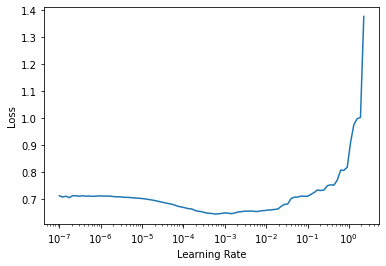

In [9]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.027890,0.687906,0.655401,0.794118,0.484848,00:32


Better model found at epoch 0 with valid_loss value: 0.6879064440727234.


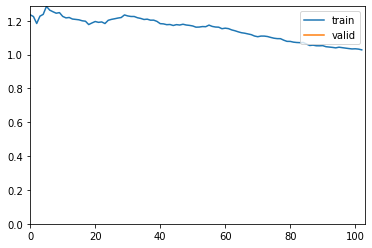

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.954106,0.610313,0.691611,0.776163,0.599327,00:37
1,0.966192,0.600911,0.698853,0.790801,0.598204,00:37
2,0.922628,0.594859,0.703681,0.803030,0.594837,00:37
3,0.888423,0.592967,0.696439,0.800310,0.580247,00:37
4,0.878037,0.577834,0.704888,0.793003,0.610550,00:37
5,0.867310,0.549929,0.719372,0.799157,0.638608,00:37
6,0.866418,0.548525,0.718769,0.791495,0.647587,00:37
7,0.843007,0.550661,0.721183,0.805991,0.634119,00:37
8,0.834456,0.543090,0.730839,0.816501,0.644220,00:37
9,0.821907,0.538106,0.722993,0.805949,0.638608,00:37


Better model found at epoch 0 with valid_loss value: 0.610312819480896.


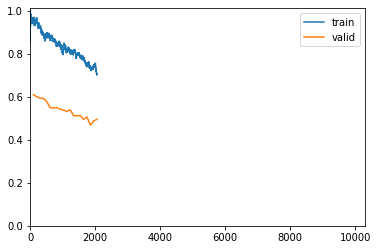

Better model found at epoch 1 with valid_loss value: 0.6009106636047363.
Better model found at epoch 2 with valid_loss value: 0.594858705997467.
Better model found at epoch 3 with valid_loss value: 0.5929669737815857.
Better model found at epoch 4 with valid_loss value: 0.5778339505195618.
Better model found at epoch 5 with valid_loss value: 0.5499286651611328.
Better model found at epoch 6 with valid_loss value: 0.5485254526138306.
Better model found at epoch 8 with valid_loss value: 0.5430904626846313.
Better model found at epoch 9 with valid_loss value: 0.5381063222885132.
Better model found at epoch 10 with valid_loss value: 0.532909095287323.
Better model found at epoch 12 with valid_loss value: 0.5130378007888794.
Better model found at epoch 13 with valid_loss value: 0.5124348402023315.
Better model found at epoch 14 with valid_loss value: 0.5123896598815918.
Better model found at epoch 15 with valid_loss value: 0.49560245871543884.
Better model found at epoch 17 with valid_loss 

In [8]:
learn.fine_tune(100,base_lr=1e-4)

In [9]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [10]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [11]:
db512 = getDataBlock(512,256)
dls512 = db512.dataloaders(trainPath,bs=64)

In [12]:
learn.freeze()

In [13]:
learn.dls=dls512

In [12]:
#learn.load('hrnet')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

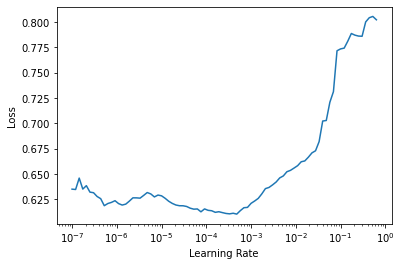

In [16]:
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.134652,0.743441,0.573394,0.550649,0.666667,00:14


Better model found at epoch 0 with valid_loss value: 0.7434411644935608.


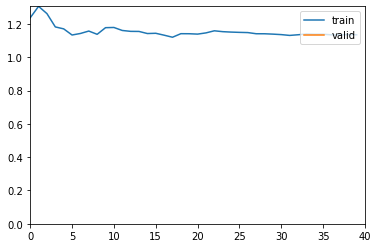

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.113793,0.750208,0.568807,0.548128,0.644654,00:16
1,1.115403,0.756771,0.564220,0.544236,0.638365,00:16
2,1.125615,0.738908,0.577982,0.558989,0.625786,00:16
3,1.094548,0.745266,0.565749,0.546448,0.628931,00:16
4,1.094972,0.742017,0.582569,0.561644,0.644654,00:16
5,1.084000,0.747100,0.582569,0.561308,0.647799,00:16


Better model found at epoch 0 with valid_loss value: 0.7502083778381348.


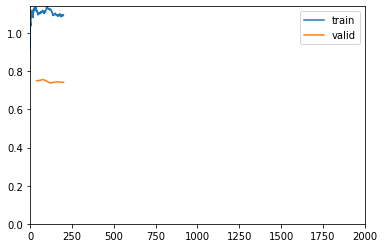

Better model found at epoch 2 with valid_loss value: 0.7389078140258789.
No improvement since epoch 2: early stopping


In [14]:
learn.fine_tune(50,base_lr=1e-5)

In [15]:
learn.dls = dlsTest

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5660146474838257.


(#4) [0.752017617225647,0.5660146474838257,0.591324200913242,0.5954022988505747]